In [2]:
from bs4 import BeautifulSoup as bs
import requests
from tqdm import tqdm 
import json
import os
import datetime
import re
import glob
import csv
import time
import pandas as pd
from nltk.stem import *
from collections import Counter
from functools import reduce
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import tokenize
#import datatable as dt   
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#To read and store dictionary
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\auror\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
#TODO
#EDA
#do Lemmatization in the Data Cleaning 
#Create all the missing tsv
#Clean and comment the code
#CHECK EFFICIENCY 1.2 and 1.3
#Parse list before saving into
# finire di aggiungere labels al punto 4 (placeAdress,city)

### 1. Data collection
## 1.1. Get the list of places

In [ ]:
total_link = []
s = requests.Session()
for n in tqdm(range(1,401)):
    url = f'https://www.atlasobscura.com/places?page={n}&sort=likes_count'
    result = s.get(url)
    soup = bs(result.text)
    puf = soup.find_all("a", {'class': 'content-card content-card-place'})
    for x in puf:
        total_link.append(x['href'])


In [ ]:
f = open('total_link.txt',"r")
total_link = f.read().split("\n")

## 1.2. Crawl places

In [ ]:
def downloadPage(start,end, array):
    count_link = ((start-1)*18)+1
    count_page = start
    
    parent_dir = f'./all_Pages'
    s = requests.Session()
    header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    for x in tqdm(range(start, end)):
        if count_link%10 == 0:
            s = requests.Session()
        if count_link%18 == 1:
            path = os.path.join(parent_dir, f"folder_{count_page}")
            os.mkdir(path)
        for y in range(18):
            url = f'https://www.atlasobscura.com{array[count_link-1]}'
            name_file = f'location_{count_link}'
            name_folder = f'folder_{count_page}'
            with open(f'./all_Pages/{name_folder}/{name_file}.html', 'w', encoding='utf8') as fp:
                req = s.get(url, headers = header)
                fp.write(req.text)
                if req.status_code != 200:
                     time.sleep(120)
                     req = s.get(url, headers = header)
                fp.write(s.get(url).text)
            if count_link%18 == 0:
                count_page += 1
            count_link += 1
           
        

## 1.3 Parse downloaded pages

In [ ]:

def save_TSV():
    os.mkdir("TSV Files")
    for x in os.listdir("all_Pages"):
        for y in os.listdir(f'all_Pages/{x}'):
            with open(f'./all_Pages/{x}/{y}', encoding='utf8') as f:
                p = f.read()
                soup =  bs(p)
                pageAttribute = []
                placeName = findPlaceName(soup)
                placeTags = findPlaceTags(soup)
                numPeopleVisited = findNumPeopleVisited(soup)
                numPeopleWant = findNumPeopleWant(soup)
                placeDesc = findDescription(soup)
                placeShortDesc = findShortDescription(soup)
                placeNearby = findNearbyPlaces(soup)
                placeAddress = findAddress(soup)
                placeAlt, placeLong = findCordinates(soup)
                placeEditors = findPostEditors(soup)
                placePubDate = findPublishingDate(soup)
                placeRelatedList = findPlaceNear(soup)
                placeRelatedPlaces = findRelatedPlaces(soup)
                placeURL = findPageURL(soup)
                with open(f'./TSV Files/{y[:-5]}.tvs', 'wt', encoding='utf8') as fp:
                    csv.writer(fp, delimiter='\t').writerow([placeName, placeTags, numPeopleVisited, numPeopleWant, placeDesc, placeShortDesc, placeNearby, placeAddress, placeAlt, placeLong, placeEditors, placePubDate, placeRelatedList, placeRelatedPlaces, placeURL])
            

In [ ]:

def download_TSV():
    os.mkdir("TSV Files")
    a = 0
    for path in tqdm(glob.glob(r"all_Pages/*/*")):
        with open(path, encoding='utf8') as f:
                    a += 1
                    p = f.read()
                    soup =  bs(p)
                    pageAttribute = []
                    placeName = findPlaceName(soup)
                    placeTags = findPlaceTags(soup)
                    placeTags = ",".join(placeTags)
                    numPeopleVisited = findNumPeopleVisited(soup)
                    numPeopleWant = findNumPeopleWant(soup)
                    placeDesc = findDescription(soup)
                    placeDesc = " ".join(placeDesc)
                    placeShortDesc = findShortDescription(soup)
                    placeNearby = findNearbyPlaces(soup)
                    placeNearby = ",".join(placeNearby)
                    placeAddress = findAddress(soup)
                    placeAlt, placeLong = findCordinates(soup)
                    placeEditors = findPostEditors(soup)
                    placeEditors = ",".join(placeEditors)
                    placePubDate = findPublishingDate(soup)
                    placeRelatedList = findPlaceNear(soup)
                    placeRelatedList = ",".join(placeRelatedList)
                    placeRelatedPlaces = findRelatedPlaces(soup)
                    placeRelatedPlaces = ",".join(placeRelatedPlaces)
                    placeURL = findPageURL(soup)
                    with open(f'./TSV Files/{a}.tvs', 'wt', encoding='utf8') as fp:
                        csv.writer(fp, delimiter='\t').writerow([placeName, placeTags, numPeopleVisited, numPeopleWant, placeDesc, placeShortDesc, placeNearby, placeAddress, placeAlt, placeLong, placeEditors, placePubDate, placeRelatedList, placeRelatedPlaces, placeURL])
        
        

In [ ]:
download_TSV()

In [ ]:
def findPlaceName(soup):
    placeName = soup.find("h1", {"class": "DDPage__header-title"})
    if placeName != None:
        placeName = placeName.text
    #placeName = re.sub('[A-Za-z0-9_.,! "]*' ,'',placeName)
    return placeName

def findPlaceTags(soup):
    tags = []
    placeTags = soup.find_all("a", {"class": "itemTags__link js-item-tags-link"})
    for tag in placeTags:
        t = tag.text.replace("\n", "")
        #t = re.sub('[A-Za-z0-9 _.,!"]*','',t)
        tags.append(t)
    return tags

def findNumPeopleVisited(soup):
    peopleVisited = soup.find_all("div", {"class": "title-md item-action-count"})
    if len(peopleVisited) > 0:
        peopleVisited = int(peopleVisited[0].text)
    return peopleVisited

def findNumPeopleWant(soup):
    peopleVisited = soup.find_all("div", {"class": "title-md item-action-count"})
    if len(peopleVisited) > 0:
        peopleVisited = int(peopleVisited[1].text)
    return peopleVisited

def findDescription(soup):
    all_description = []
    descriptions = soup.find_all("div", {"class": "DDP__body-copy"})
    for description in descriptions:
        d = description.text.replace("\n","")
        all_description.append(d)
    return all_description

def findShortDescription(soup):
    shortDescription = soup.find("h3", {"class": "DDPage__header-dek"})
    if shortDescription != None:
        shortDescription = shortDescription.text.replace("\n", "")
    return shortDescription

def findNearbyPlaces(soup):
    nearPlaces = []
    nearbyPlaces = soup.find_all("div", {"class": "DDPageSiderailRecirc__item-title"})
    if nearbyPlaces != None:
        for place in nearbyPlaces:
            p = place.text.replace("\n","")
            nearPlaces.append(p)
        #Convert the list to set, and then back again to list to remove repetition
    return set(nearPlaces)

def findAddress(soup):
    strings = []
    adress_strings = soup.find("address", {"class": "DDPageSiderail__address"})
    if adress_strings != None:
        adress_strings = adress_strings.find("div")
        for info in adress_strings:
            s = info.text.replace("\n", "")
            if s != "":
                strings.append(s)
        if len(strings) > 3:
            return " ".join(strings[:3])
    else:
        return " "

def findCordinates(soup):

    cordinates = soup.find("div", {"class":"DDPageSiderail__coordinates js-copy-coordinates"})
    if cordinates != None:
        return cordinates.text.replace("\n", "").replace(" ","").split(",")
    return " ", " "

def findPostEditors(soup):
    all_editors =[]
    editors = soup.find_all("a", {"class":"DDPContributorsList__contributor"})         
    for person in editors:
        s = person.text.replace("\n", "")
        all_editors.append(s)
    return all_editors

def findPublishingDate(soup):
    #Pick the right info
    dateString = soup.find("div", {"class":"DDPContributor__name"}) 
    #Let's clean the string
    if dateString != None:
        s = dateString.text.replace("\n", "")
        #Let's modify it for the right format of datetime
        split = s.split()
        #Let's convert the string Month into the corrispondent number by using "strptime()" 
        split[0] = str(datetime.datetime.strptime(split[0], '%B').month)
        #My format
        format = "%m %d, %Y"
        #Convert from String to datetime
        date = datetime.datetime.strptime(" ".join(split), format)
        return date
    else:
        return ""

def findPlaceNear(soup):
    lists =[]
    relatedLists = soup.find("div", {"data-gtm-template":"DDP Footer Recirc Nearby"})
    if relatedLists != None:
        relatedLists = relatedLists.find_all("h3", {"class":"Card__heading --content-card-v2-title js-title-content"})
        for list in relatedLists:
            s = list.text.replace("\n", "")
            #s = re.sub('[A-Za-z0-9 _.,!"]*','',s)
            lists.append(s)
    return lists

def findRelatedPlaces(soup):
    lists =[]
    relatedLists = soup.find("div", {"data-gtm-template":"DDP Footer Recirc Related"})
    if relatedLists != None:
        relatedLists = relatedLists.find_all("h3", {"class":"Card__heading --content-card-v2-title js-title-content"})
        for list in relatedLists:
            s = list.text.replace("\n", "")
            #s = re.sub('[A-Za-z0-9 _.,!"]*','',s)
            lists.append(s)
    return lists

def findPageURL(soup):
    numVisitedPeople = soup.find("link", {"rel":"canonical"})
    return numVisitedPeople['href']



## Load all the tsv file into one pandas dataframe

We decided to save all the .tsv file as one joined .csv where every file rappresents one row of the .csv file, so that we can work and access the data without having to read 7200 tsv file each time. The data are stored in the "tsv_dataframe"

This mean that the function load_tsv() has only been executed once. The other iteration we just read the .csv file

In [ ]:

def load_tsv() -> pd.DataFrame:
    tsv = []
    dtypes = {}
    for x in tqdm(os.listdir("TSV Files")):
        df = pd.read_csv(f'TSV Files/{x}',
            sep="\t",
            header=None,
            names=["placeName", "placeTags", "numPeopleVisited", "numPeopleWant", "placeDesc", "placeShortDesc", "placeNearby","placeAdress", "placeAlt", "placeLong", "placeEditors","placePubDate", "placeRelatedList", "placeRelatedPlace", "placeURL"])
        tsv.append(df)

    return pd.concat(tsv)

In [35]:
# data = load_tsv()
data = pd.read_csv("tsv_dataframe.csv",index_col=0)

#Reset Index
data.reset_index(inplace = True, drop=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   placeName          7200 non-null   object 
 1   placeTags          7166 non-null   object 
 2   numPeopleVisited   7200 non-null   int64  
 3   numPeopleWant      7200 non-null   int64  
 4   placeDesc          7200 non-null   object 
 5   placeShortDesc     7200 non-null   object 
 6   placeNearby        7200 non-null   object 
 7   placeAdress        7166 non-null   object 
 8   placeAlt           7200 non-null   float64
 9   placeLong          7200 non-null   float64
 10  placeEditors       7194 non-null   object 
 11  placePubDate       7199 non-null   object 
 12  placeRelatedList   7199 non-null   object 
 13  placeRelatedPlace  7166 non-null   object 
 14  placeURL           7200 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 843.9+ KB


In [28]:
data.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedList,placeRelatedPlace,placeURL
0,City Hall Station,"subways,subterranean,infrastructure,subterrane...",1834,8603,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"The Sugar House Prison Window,Tunnel Number 3,...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"Rebekah Otto,Annetta Black,Allan,charding407,w...",2010-05-08 00:00:00,"African Burial Ground National Monument,Tunnel...","Crystal Palace Subway,Moscow Metro Stations,Ro...",https://www.atlasobscura.com/places/city-hall-...
1,The Winchester Mystery House,"follies and grottoes,outsider architecture,ecc...",3723,5209,In 1886 an eccentric woman named Sarah Winches...,A peculiar mansion built by the troubled heir ...,"Rosicrucian Park,Rosicrucian Egyptian Museum,S...","525 South Winchester Boulevard San Jose, Calif...",37.3189,-121.9506,"mbison,Avoiding Regret,PrestonW,Collin,Destina...",2008-11-21 00:00:00,"Santana Row Chess Plaza,Rosicrucian Park,Rosic...","Casa de Piedra (Stone House),Portmeirion Villa...",https://www.atlasobscura.com/places/winchester...
2,Center for Puppetry Arts,"sesame street,puppets,museums",705,1027,"If you know your Gonzo from your Gelflings, yo...",The largest puppetry museum in the USA houses ...,"Breman Museum,The Consulate,Atlanta Monetary M...","1404 Spring St Atlanta, Georgia United States",33.7927,-84.3896,"kendallmbailey,Martin,andydoesit,We All Pod Do...",2018-11-12 00:00:00,"Breman Museum,Atlanta Monetary Museum,The Cons...","Portland Puppet Museum,Museu da Marioneta (Mus...",https://www.atlasobscura.com/places/center-for...
3,Amityville Horror House,"hoaxes and pseudoscience,haunted,film location...",367,831,"On a cold November night in 1974, Amityville, ...",The site of a tragic massacre that spawned a m...,"The Long Island Puppet Theater,Pilgrim Psychia...","112 Ocean Avenue Amityville, New York, 11701 U...",40.6665,-73.4143,"EricGrundhauser,MandrewPatinkin,lendog666,Mart...",2013-10-17 00:00:00,"The Long Island Puppet Theater,Fire Island Lig...","Conanicut Island Lighthouse,Lovell Health Hous...",https://www.atlasobscura.com/places/amityville...
4,Yuma Territorial Prison,"prisons,crime and punishment",422,833,"On July 1, 1876, the first seven inmates enter...",Walk through the actual strap iron cells and s...,"Valley of the Names,Felicity, California: Cent...","1 Prison Hill Rd Yuma, Arizona, 85364 United S...",32.7266,-114.6144,"desertfairy,mbison,CorpseLady84,Avoiding Regre...",2010-04-01 00:00:00,"Felicity, California: Center of the World,Vall...","Buckley's Cave,Palazzo d'Avalos,Oxford Castle ...",https://www.atlasobscura.com/places/yuma-terri...


In [36]:
data = data.fillna("")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   placeName          7200 non-null   object 
 1   placeTags          7200 non-null   object 
 2   numPeopleVisited   7200 non-null   int64  
 3   numPeopleWant      7200 non-null   int64  
 4   placeDesc          7200 non-null   object 
 5   placeShortDesc     7200 non-null   object 
 6   placeNearby        7200 non-null   object 
 7   placeAdress        7200 non-null   object 
 8   placeAlt           7200 non-null   float64
 9   placeLong          7200 non-null   float64
 10  placeEditors       7200 non-null   object 
 11  placePubDate       7200 non-null   object 
 12  placeRelatedList   7200 non-null   object 
 13  placeRelatedPlace  7200 non-null   object 
 14  placeURL           7200 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 843.9+ KB


# 2. Search Engine

In [19]:
#TODO
#1. cambiare 'dic1' con 'vocabulary'
#2. cambiare 'dic2' con 'inverted_index'
#3. cambiare 'dic3' con 'inverted_index_2'
#4. calcolare nuovo dizionario 3

### funzioni poi da togliere dal file principale

In [37]:


def remove_punctuations(string) -> list:
    # first we remove the punctuations
    # in order to do it we need to tekenize the string with the function tokenize and then applying the function RegexpTokenizer
    return RegexpTokenizer(r'\w+').tokenize(string)


def stemming(string) -> list:
    # now we move forward with the stemming
    porter = PorterStemmer()
    string_stem=[porter.stem(word) for word in string]
    # we can now return the cleaned string 
    return string_stem

def remove_stopwords(string) -> list:
    # after this we can now remove all the stopwords in each word in string_t
    return  [word for word in string if not word.lower() in set(stopwords.words("english"))]
    # now we move forward with the stemming

def remove_numbers(string) -> list:
    for num in range(len(string)):
        if any(chr.isdigit() for chr in string[num]):
            string[num] = ''.join((x for x in string[num] if not x.isdigit()))
    return string



def cleaning(string) -> list:
    #I apply all the function for cleaning the string
    string = string.lower()
    string = remove_punctuations(string)
    string = remove_stopwords(string)
    string = remove_numbers(string)
    string = stemming(string)

    #return a list containing all the words of the original string after the cleaning
    return string

In [38]:
def save_dic(dic, name):
    with open(f'./Dictionary/{name}.pkl', 'wb') as f:
        pickle.dump(dic, f)

In [39]:
def read_dic(name):
    with open(f'./Dictionary/{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
        return loaded_dict

Before starting the search engines, since we'll look for words in the descriptions of each place, we clean the collected placeDesc for every place in the dataset.  
In order to have later a more readable output we'll not sobsitute the column placeDesc with the one with all the cleaned descriptions but we'll add another column to our dataset 'data'.   
In particular the function *cleaning*, that we apply in the next cell at every description, will:
- convert all the upper characters in lower ones;
- remove all the punctuations;
- remove all the stopwords;
- remove all numbers;
- stem the string.

Let's create a new column with the clean descriptions:

In [ ]:
#The function cleaning takes as input a string (a description) and returns the cleaned description as a list of strings
data['cleanDesc'] = data.placeDesc.apply(lambda row: " ".join(cleaning(row)))

Now we save the data as a .csv file for future uses so that we don't need to run again the previous cell.

In [11]:
data.to_csv("dataframe_clean.csv")

Run the following cell if you want the original dataframe with a column 'cleanDesc' with the cleaned description.

In [103]:
data = pd.read_csv("dataframe_clean.csv")
data.fillna('', inplace=True)

## 2.1 Conjunctive query

### 2.1.1) Create your index!

The next function *createFirstDic*, given the dataset 'data', will return the dictionary *vocabulary* .     
Vocabulary will be such that every key is a unique word contained in the descriptions and its corresponing value is an integer that identifies that word.

In [41]:
def createFirstDic(data: pd.DataFrame, nameCol: str) -> dict:
    # first we create an empty dictionary
    dic = {}
    value = 1
    for description in tqdm(data[nameCol]):
        for word in description.split():
            # if the word is already in the dictionary keys this mean that it has already even a corresponding number and
            # so we can skip to the next word in the fixed description
            if word in dic.keys():
                continue
            # otherwise we create a new key named 'word' with value = value and then we upgrade value
            else:
                dic[word] = value
                value += 1
    return dic

We can now call the function createFirstDic and store its output as *vocabulary*:

In [50]:
vocabulary = createFirstDic(data, "cleanDesc")

100%|██████████| 7200/7200 [00:00<00:00, 24868.95it/s]


The second dictionary that we'll need for the first search engine is *inverted index* that is such that every key is an integer that identifies a word and its corresponding value is a set of all the document_id that contain that word.    
The following function *createSecondDic*, given as input the dataset 'data' and the dictionary 'vocabulary', will return the *inverted index* dictionary.  

In [52]:
def createSecondDic(data: pd.DataFrame, vocabulary: dict, nameCol: str) -> dict:
    dic = {}
    # a will keep track of the row index of the data
    a = 0
    # we take one description at a time from the column 'cleanDesc'
    for description in tqdm(data[nameCol]):
        # for every word in the fixed description 
        for word in description.split():
            # if the corresponding integer of the word is already in the keys of the inverted_index then we need to
            # add the document_id of the fixed description to the already existing set
            if vocabulary[word] in dic.keys():
                dic[vocabulary[word]].add(data.placeName[a])
            # otherwise we create a new key named as the corresponding integer of the word with value equal to a set that 
            # contains the document_id of the fixed description
            else:
                dic[vocabulary[word]] = set([data.placeName[a]])
        a += 1
    return dic

    

We can now call the function createSecondDic and store its output as *inverted_index*:

In [53]:
inverted_index = createSecondDic(data,vocabulary, "cleanDesc")

100%|██████████| 7200/7200 [00:09<00:00, 787.68it/s]


Even in this case we can store the two dictionary in a separate file so that we don't need to run the codes everytime we need them.

In [56]:
save_dic(vocabulary, "vocabulary")
save_dic(inverted_index,"inverted_index")

Run the following cell if you want the dictionaries *vocabulary* and *inverted_index*.

In [57]:
vocabulary = read_dic("vocabulary")
inverted_index = read_dic("inverted_index")

### 2.1.2) Execute the query

First of all we ask the user which query do we have to look for in the places descriptions and we store it as a string named *q*:

In [58]:
q = input('Insert the query that you want to find in the places descriptions: ')

Before starting the first search engine with the query *q* we need to clean q too.

In [59]:
q = cleaning(q) 
# now q is a list that contains the cleaned word of the input query
print(q)

['american', 'museum']


The next function *query* is our first search engine that, given as input a list of words (the query), it will return as output a list of all the documents_id that contain all the words in the list.

In [60]:
def query(list, vocabulary, inverted_index):
    # s is the set of the documents_id that contain the first word in the query
    s = inverted_index[vocabulary[list[0]]]
    # starting from the second word in the query till the last we'll intersect the set s with the set of all the documents_id 
    # that contain the fixed word 
    for x in range(1, len(list)):
        s.intersection(inverted_index[vocabulary[list[x]]])
    return s

We can now execute the previous function with our query q:

In [62]:
s = query(q,vocabulary,inverted_index)
# s is the set with all the documents_id of all the descriptions that contain all the words in the query

We can now create a new dataset *res_query* with just the places we're interested in:

In [63]:
res_query = data[data['placeName'].isin(list(s))]

With the following code we'll show the result of the first search engine.    
In particular we'll show just the places names, their description and their URL.

In [64]:
res_query[['placeName','placeDesc','placeURL']]

,placeName,placeDesc,placeURL
3,Amityville Horror House,"On a cold November night in 1974, Amityville, ...",https://www.atlasobscura.com/places/amityville...
6,American Prohibition Museum,When the 18th Amendment to the U.S. Constituti...,https://www.atlasobscura.com/places/american-p...
13,Wild Blueberry Land,There is no shortage of bizarre American highw...,https://www.atlasobscura.com/places/wild-blueb...
39,The Avrocar,The year was 1952 and the Cold War was in full...,https://www.atlasobscura.com/places/avrocar
59,Laurel Dinosaur Park,"During the 18th and 19th centuries, clay forma...",https://www.atlasobscura.com/places/laurel-din...
...,...,...,...
7155,Garden of Eden Trail,In the 1950s retired lawyer and Republican can...,https://www.atlasobscura.com/places/garden-of-...
7183,Theodore Roosevelt Birthplace Museum,Behind an otherwise innocuous (if immaculately...,https://www.atlasobscura.com/places/theodore-r...
7184,Cabaret Mechanical Theatre,"It’s not a theater and it’s not a cabaret, so ...",https://www.atlasobscura.com/places/cabaret-me...
7186,Timothy Demonbreun's Cave,Seemingly little more than a wide crack in the...,https://www.atlasobscura.com/places/timothy-de...


## 2.2) Conjunctive query & Ranking score

### 2.2.1) Inverted index

Now we have to create another dictionary *inverted_index_2* in which we store also the *tfidf* values of the words.   
As suggested, since the tfidf are invariant for the query we can precalculate them before and store them in a dataframe *df*.    
In order to do this we use the module *TfidfVectorizer* that is able to compute the tfidf values of all the unique words in the places descriptions.

In [65]:
vectorizer = TfidfVectorizer(use_idf=True, analyzer='word',sublinear_tf=True)
x =vectorizer.fit_transform(data["cleanDesc"]).todense()
df = pd.DataFrame(x, columns = vectorizer.get_feature_names_out())

*df* now is a dataframe such that every row corresponds to a place's description and every column corresponds to a word found in the descriptions.    
Using now *df* and the two dictionary previously created, we can now create *inverted_index_2* that will be such that every key is an integer that corresponds to a word and its value is a list of touples (document_id, tfidf{word,document_id}).

In [66]:
def createInvertedIndex(data, vocabulary, nameCol, matrix):
    inverted_index2 = {}
    # for every word in columns name of df
    a = 0
    for word in tqdm(matrix.columns):
        # we fix a row in df that correspond to a place's description
        for place in matrix.index:
            # if in the keys of our dictionary there already is the integer that corresponds to our word then we just have to 
            # add a tuple to our existing set with the placeName and the tfidf score of that word in the fixed description
            if vocabulary[word] in inverted_index2.keys() and matrix[word][place] != 0:
                inverted_index2[vocabulary[word]].add((data[nameCol][place], matrix[word][place]))
            # otherwise we can add a new key with value a set that contains a tuple (placeName,tfidf{word,placeName})
            else:
                inverted_index2[vocabulary[word]] = set((data[nameCol][place], matrix[word][place]))           
    return inverted_index2

We can now execute the previous function with as input our *data*, *vocabulary* and *df*:

In [67]:
inverted_index_2 = createInvertedIndex(data, vocabulary, "cleanDesc", df)

  4%|▍         | 1708/38574 [03:00<1:05:05,  9.44it/s]


KeyboardInterrupt: 

As previously done with the other two dictionary, we store *inverted_index_2* in a separate file so that we don't have to compute it again.

In [20]:
save_dic(inverted_index_2, "inverted_index_2")

Run the following cell if you want the dictionariy *inverted_index_2*.

In [8]:
inverted_index_2 = read_dic("inverted_index_2")

Have a look at our dictionary:

In [ ]:
print(inverted_index_2)

### 2.2.2) Execute the query

Since later we'll need again to compute cosine similarity between a query given by the user and a column of our dataframe *data* we've decided to create a generic function that is able to:
- find the matrix of *tfidf* scores of  the query and the words in a given column of *data* (*nameCol*);
- create the dictionary *vocabulary* and *inverted_index* with words in *nameCol*;
- look for all the places that contain the words in the query in *nameCol*;
- compute the cosine similarity;
- sort the dataframe by the cosine similarity.

In [80]:
def query_tfidf(data: pd.DataFrame, nameCol: str, q: str) -> pd.DataFrame:
    #We need to clean the query
    q = cleaning(q) 

    # now q is a list that contains the cleaned word of the input query
    vectorizer = TfidfVectorizer(use_idf=True, analyzer='word',sublinear_tf=True)
    x =vectorizer.fit_transform(data["cleanDesc"]).todense()
    df = pd.DataFrame(x, columns = vectorizer.get_feature_names_out())
    qv = vectorizer.transform([" ".join(q)]).todense()
    
    # since later we'll need to compute the norm of this vector, we create an np array with the tfidf of the query
    qv = np.array(qv[0,:])

    vocabulary = createFirstDic(data, nameCol)
    inverted_index = createSecondDic(data, vocabulary, nameCol)
    s = query(q,vocabulary,inverted_index)
    
    # res_query will be our new dataframe such that contains only the places with description that 
    # contains all the words in the query
    res_query = data[data['placeName'].isin(list(s))]
    
    # scores will be a list with all the cosine similarityy score of a document in nameCol with respect to the query
    scores = cosine_score(res_query,df,qv)
    res_query.insert(res_query.shape[1], f"CS_{nameCol}",scores )   
    
    # sort res_query by the cosine similarity scores
    res_query = res_query.sort_values(by=[f"CS_{nameCol}"],ascending=False)

    return res_query


The next function *cosine_score* given *res_query*, *df* and *qv* is able to compute the cosine similarity of the places descriptions with respect to the query.    
Let's remark what is the cosine similarity of a description to a query:
$$cosine similarity = \frac{sentence\cdot query}{\Vert sentence\Vert  \Vert query\Vert}$$
where *sentence* is the tfidf vector of the given sentence and *query* is the tfidf of the query.

In [81]:
def cosine_score(res_query,df,qv):
    # first we create an empty list in which store all the cosine similarity scores
    scores = []
    # for every place in res_query we compute the cosine similarity as shown before and append that value in the list scores
    for place in res_query.index:
        scores.append(np.dot(np.array(df.iloc[place]).reshape(1,df.shape[1])[0],qv[0]) / (np.linalg.norm(np.array(df.iloc[place]).reshape(1,df.shape[1])[0])*np.linalg.norm(qv[0]) ))
    return scores

Finally we can ask the user the query he wants to find in the places descriptions and execute the function *query_tfidf*:

In [82]:
q = input('Insert the query that you want to find in the places descriptions: ')
final_query = query_tfidf(data, "cleanDesc", q)
final_query[['placeName','placeDesc','placeURL','CS_cleanDesc']].head(10)

100%|██████████| 7200/7200 [00:09<00:00, 798.20it/s]


,placeName,placeDesc,placeURL,CS_cleanDesc
4563,Self-Taught Genius Gallery,"In 2017, the American Folk Art Museum in Manha...",https://www.atlasobscura.com/places/self-taugh...,0.181039
605,Renwick Gallery,The Renwick Gallery building has the distincti...,https://www.atlasobscura.com/places/renwick-ga...,0.180539
2216,American Writers Museum,The American Writers Museum—tucked away on the...,https://www.atlasobscura.com/places/american-w...,0.176558
2585,Mount Angel Abbey Museum,The Mount Angel Abbey Museum is a very eclecti...,https://www.atlasobscura.com/places/mount-ange...,0.168144
4413,The American Pigeon Museum,"Many people, especially in big cities, view pi...",https://www.atlasobscura.com/places/the-americ...,0.167326
102,Museum of Mourning Art,Mourning and personal response to death are un...,https://www.atlasobscura.com/places/museum-of-...,0.166433
5208,Indian Steps Museum,"Constructed by a local lawyer from 1908-1912, ...",https://www.atlasobscura.com/places/indian-ste...,0.161671
3196,The American Kennel Club Museum of the Dog,At the intersection of the Venn diagram where ...,https://www.atlasobscura.com/places/the-americ...,0.161211
515,Museum of Russian Culture,"When you think San Francisco, you probably don...",https://www.atlasobscura.com/places/museum-of-...,0.160452
6185,Harvard Museum of Natural History,Collecting three different institutions into o...,https://www.atlasobscura.com/places/harvard-mu...,0.159486


## 3. Define a new score!

Our idea is to create a new score based on the number of people who have already been in a place or on the number of people who want to see that place. 
First we let the user insert the query that he want to search in the places descriptions.   
Then we let the user choose the number of places he wants to see in the final output and if he wants to sort the places by the scores of *numPeopleVisited* or of *numPeopleWant*.  
As last input we ask the user if he wants to see the most popular ones or the least.

In [104]:
q = input("Insert the words that you want to be found in the description's places: ")

As before, the first thing that we do is to clean the query:

In [105]:
q = cleaning(q) 
# now q is a list that contains the cleaned word of the input query
print(q)

['american', 'museum']


Then we execute the first search engine as in 2.1 with the query given by the user:

In [106]:
s = query(q,vocabulary,inverted_index)
res_query = data[data['placeName'].isin(list(s))]
res_query.reset_index(inplace = True, drop=True) 

Now we can ask the user which type of score he wants and store the choice in a variable *n*

In [107]:
n = int(input('What is the top rank visualization that you want to have? \nInsert "1" if you prefer that is by number of tourists. \nInsert "2" if you prefer that is by number of people that want to visit the site.\n'))

Then we can ask to insert the number of places he wants to see (*k*) and if he wants to see the most popular or the least (*m*):

In [108]:
k = int(input('Insert k the number of places that you want to visualize:')) 
m = int(input('Insert "1" if you want to see the k most popular places or insert "2" if you want to see the less famous places:'))

The next cell contains the function *new_score*. Given the places that contains all the words in the query and the choices made by the user (*n*, *k*, *m*) this function will compute the proper new score. The new score will be calculated as the *numPeopleVisited* or *numPeopleWant* divided by the max value in the same column in the dataframe *res_query*. At the end of the function we sort by this new score (in ascending or descending order depending on the user's choice) and return the ordered res_query.

In [109]:
def new_score(res_query,n,k,m):
    scores = []
    if n == 1:
        by = res_query['numPeopleVisited']
    else:
        by = res_query['numPeopleWant']
    max_value = by.max()
    for i in range(res_query.shape[0]):
        scores.append(round(by[i]/max_value,4))
    res_query.insert(res_query.shape[1], "scores", scores)
    if m == 1:
        res_query = res_query.sort_values(by=['scores'],ascending=False)
    else:
        res_query = res_query.sort_values(by=['scores'],ascending=True)
        
    return res_query

We can now execute the *new_score* function and print the first *k* element of the final dataframe:

In [110]:
resquery = new_score(res_query,n,k,m).head(k)
resquery[['placeName','placeDesc','placeURL','scores']]

,placeName,placeDesc,placeURL,scores
673,Alcatraz Island,"Alcatraz, also referred to as “The Rock,” is r...",https://www.atlasobscura.com/places/alcatraz-i...,1.0000
764,Shakespeare and Company,"In 1951, an eccentric American named George Wh...",https://www.atlasobscura.com/places/shakespear...,0.6016
84,Garden of the Gods,Colorado is famous for its grand red rock form...,https://www.atlasobscura.com/places/garden-of-...,0.5859
729,Multnomah Falls,"Only a 30-minute drive from Portland, Oregon, ...",https://www.atlasobscura.com/places/multnomah-...,0.5359
793,Blue Mustang,The “Blue Mustang” sculpture was created by th...,https://www.atlasobscura.com/places/blue-mustang,0.5272
273,Japanese Tea Garden,The Japanese Tea Garden in Golden Gate Park is...,https://www.atlasobscura.com/places/japanese-t...,0.4865
726,Marie Laveau's Tomb,Marie Laveau was a famous and powerful voodoo ...,https://www.atlasobscura.com/places/marie-lave...,0.4822
674,The Witch House of Salem,The Salem witchcraft trials took place between...,https://www.atlasobscura.com/places/witch-hous...,0.4785
16,Philadelphia City Hall,Given that Philadelphia is the birthplace of o...,https://www.atlasobscura.com/places/philadelph...,0.4721
224,Old North Church,The Old North Church is a national historic la...,https://www.atlasobscura.com/places/old-north-...,0.4696


## 4 

The idea is to create a map to visualize better all the places selected by the query in exercise 3. In the map all the placed will be represented by points with different colors by continent.

Hovering the pointer over each place will display the name, city, address, country and the number of people that visited that place.

In [111]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [112]:
#To begin we reset the index for the k places and we create two lists (city, country)
resquery.reset_index(inplace = True, drop=True)
city=[]
country=[]

for i in range(resquery.shape[0]):
    # this for cicle will iterate all the places saving in lat and long the latitude and longitude
    lat = resquery.placeAlt[i]
    lon = resquery.placeLong[i]
    # geolocator is a library that is able to take the address, city and country giving the latitude and logitude.
    location = geolocator.reverse(str(lat)+","+str(lon))
    address = location.raw['address']
    city.append(address.get('state', ''))
    country.append(address.get('country', ''))
    
    
# reach this point we create two columns with the city/state and country
resquery.insert(resquery.shape[1], "city/state", city)
resquery.insert(resquery.shape[1], "country", country)


In [114]:
# it's time now to create the map. Scatter_geo will do this after we insert all the informations require.

import plotly.express as px
import plotly.graph_objs as go

fig = px.scatter_geo(resquery,lat="placeAlt", lon="placeLong",
                     size="numPeopleVisited", color="country",
                     projection="natural earth",
                     labels={'placeAlt':'latitude','placeLong':'longitude','placeAdress':'adress','numPeopleVisited':'number of people who visited this place'},
                     hover_data=["placeAdress","city/state"],hover_name="placeName")
fig.show()

#### command line

In [102]:
#Command Line question
forCommandLine = data[data["placeAdress"].str.contains("Italy")]
print("Total number of places in Italy:", len(forCommandLine))
print("The average of visitors in Italy:", int((forCommandLine["numPeopleVisited"].sum())))
print("Who wants to visit England (in total):", forCommandLine["numPeopleWant"].sum())
print()

forCommandLine2 = data[data["placeAdress"].str.contains("Spain")]
print("Total number of places in Spain:", len(forCommandLine2))
print("The average of visitors in Spain:", int((forCommandLine2["numPeopleVisited"].sum())/len(forCommandLine)))
print("Who wants to visit England (in total):", forCommandLine2["numPeopleWant"].sum())
print()


forCommandLine3 = data[data["placeAdress"].str.contains("France")]
print("Total number of places in France:", len(forCommandLine3))
print("The average of visitors in France:", int((forCommandLine3["numPeopleVisited"].sum())/len(forCommandLine)))
print("Who wants to visit France (in total):", forCommandLine3["numPeopleWant"].sum())
print()


forCommandLine4 = data[data["placeAdress"].str.contains("England")]
print("Total number of places in England:", len(forCommandLine4))
print("The average of visitors in England:", int((forCommandLine4["numPeopleVisited"].sum())/len(forCommandLine4)))
print("Who wants to visit England (in total):", forCommandLine4["numPeopleWant"].sum())
print()



forCommandLine5 = data[data["placeAdress"].str.contains("United States")]
print("Total number of places in the United States:", len(forCommandLine5))
print("The average of visitors in United States:", int((forCommandLine5["numPeopleVisited"].sum())/len(forCommandLine5)))
print("Who wants to visit United States (in total):", forCommandLine5["numPeopleWant"].sum())
print()

Total number of places in Italy: 182
The average of visitors in Italy: 68791
Who wants to visit England (in total): 152906

Total number of places in Spain: 82
The average of visitors in Spain: 212
Who wants to visit England (in total): 64587

Total number of places in France: 188
The average of visitors in France: 446
Who wants to visit France (in total): 189973

Total number of places in England: 367
The average of visitors in England: 476
Who wants to visit England (in total): 389820

Total number of places in the United States: 4234
The average of visitors in United States: 431
Who wants to visit United States (in total): 3966022



## 5 Bonus Question

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#TODO
#Gestisci il caso in cui non siano tutti e tre, come caloli il final score?
#gestisci il caso inc ui una parola non sia nel documento (=print(parola non presente in nessun documento))
#Ottimizzazione: carica i dizionari al posto di prenderli sempre

In [75]:
#The function cleaning takes as input a string (a description) and returns the cleaned description as a list of strings
data['cleanName'] = data.placeName.apply(lambda row: " ".join(cleaning(row)))

In [78]:
#The function cleaning takes as input a string (a description) and returns the cleaned description as a list of strings
data['cleanAdress'] = data.placeAdress.apply(lambda row: " ".join(cleaning(row)))

In [156]:
def query_function(data, nameCol,q):
    dic1 = createFirstDic(data, nameCol)
    dic2 = createSecondDic(data, dic1, nameCol)
    s = query(q,dic1,dic2)
    return s

In [157]:
def complex_query(data):
    boolDesc = False
    boolName = False
    boolAdress = False

    set_list = []
    q_list = []
    q1 = input('Insert the query that you want to find in the places descriptions: [if you dont want to search for anything just press Enter]')
    if q1 != "":
        boolDesc = True
        q1_clean = cleaning(q1)
        set_list.append(query_function(data, "cleanDesc", q1_clean))
        q_list.append(q1_clean)
    else:
        q_list.append("")

    q2 = input('Insert the query that you want to find in the Names: [if you dont want to search for anything just press Enter]')
    if q2 != "":
        boolName = True
        q2_clean = cleaning(q2)
        set_list.append(query_function(data, "cleanName", q2_clean))
        q_list.append(q2_clean)
    else:
        q_list.append("")


    q3 = input('Insert the query that you want to find in the Adress: [if you dont want to search for anything just press Enter]')
    if q3 != "":
        boolAdress = True
        q3_clean = cleaning(q3)
        set_list.append(query_function(data, "cleanAdress", q3_clean))
        q_list.append(q3_clean)
    else:
        q_list.append("")


    bool_arr = [boolDesc, boolName, boolAdress]
    return set_list, bool_arr, q_list

In [158]:
def find_df_qv(data,q,colName):
    vectorizer = TfidfVectorizer(use_idf=True, analyzer='word',sublinear_tf=True)
    x =vectorizer.fit_transform(data[colName]).todense()
    df = pd.DataFrame(x, columns = vectorizer.get_feature_names_out())
    qv = vectorizer.transform([" ".join(q)]).todense()
    return df, qv


In [159]:
def query_tfidf(data: pd.DataFrame) -> pd.DataFrame:
    
    set_list, bool_arr, q_list = complex_query(data)

    dic = {0: "cleanDesc", 1: "cleanName", 2: "cleanAdress"}

    #create an interesction of all the query
    s = set()
    if len(set_list) > 0:   
        s = set_list[0]
        for x in set_list:
            s = s.intersection(x)

    # res_query will be our new dataframe such that contains only the places with description that 
    # contains all the words in the query
    res_query = data[data['placeName'].isin(s)]

    for bool in range(len(bool_arr)):
        if bool_arr[bool] == True:
            df, qv = find_df_qv(data, q_list[bool], dic[bool])

            # since later we'll need to compute the norm of this vector, we create an np array with the tfidf of the query
            qv = np.array(qv[0,:])

            scores = cosine_score(res_query,df,qv)    
            res_query.insert(res_query.shape[1], f"CS_{dic[bool]}",scores ) 

    return res_query

In [168]:
prova = query_tfidf(data)

100%|██████████| 7200/7200 [00:00<00:00, 52610.47it/s]


In [169]:
prova

,Unnamed: 0,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,...,placeEditors,placePubDate,placeRelatedList,placeRelatedPlace,placeURL,cleanDesc,cleanName,cleanAdress,CS_cleanDesc,CS_cleanName
6,6,American Prohibition Museum,"speakeasies,prohibition,law,food museums,alcoh...",368,832,When the 18th Amendment to the U.S. Constituti...,"Performers, intricate sets, and a real speakea...","The Paris Market,Riverside Plant Hotel,The Mar...","209 W. St. Julian Street Savannah, Georgia Uni...",32.0806,...,"Edward Denny,Collector of Experiences,theparan...",2018-11-26 00:00:00,"The Paris Market,Riverside Plant Hotel,The Mar...","Booze History Museum,Linos tou Charilaou (Omod...",https://www.atlasobscura.com/places/american-p...,th amend u constitut outlaw alcohol deleteri d...,american prohibit museum,w st julian street savannah georgia unit state,0.081833,0.565670
146,146,American Classic Arcade Museum,"pinball,arcades,video games,games,museums and ...",468,1022,"Housed inside New Hampshire’s Funspot, which h...",The largest arcade museum in the world chronic...,"Endicott Rock,Archie Andrews Statue,Claude Rai...","579 Endicott Street North Laconia, New Hampshi...",43.6130,...,"thomasharper,tehutika,Mark Mones,e1savage",2014-04-04 00:00:00,"Endicott Rock,Archie Andrews Statue,Claude Rai...","Asheville Pinball Museum,Pinball Hall of Fame,...",https://www.atlasobscura.com/places/american-c...,hous insid new hampshir funspot hold guin worl...,american classic arcad museum,endicott street north laconia new hampshir u...,0.097970,0.483281
197,197,American Museum of Western Art,"brothels,americana,hotels,museums and collecti...",323,806,Housed in the old Navarre building across from...,The huge collection of paintings of the Americ...,"Mile-High Steps at the Colorado State Capitol,...","1727 Tremont Place Denver, Colorado United States",39.7447,...,"randibrown,bribolio,cyccommute",2017-11-27 00:00:00,"Denver Omelet Plaque,Big Blue Bear,Mile-High S...","Null Stern Hotel Museum,French Shore Interpret...",https://www.atlasobscura.com/places/american-m...,hous old navarr build across brown palac hotel...,american museum western art,tremont place denver colorado unit state,0.145389,0.525209
385,385,American Gothic House,"eccentric homes,shops,homes,architectural oddi...",380,784,Made famous in the 1930 painting by Grant Wood...,Home with Gothic windows featured in a famous ...,"What Cheer,Maharishi Vedic City,Richard Proenn...","300 Gothic St. Eldon, Iowa, 52554 United States",40.9211,...,"Facebook550112500,renkessler,smcripps04,drvand...",2011-06-29 00:00:00,"Maharishi Vedic City,What Cheer,Richard Proenn...","Krämerbrücke,Castello di Amorosa,Margalef,Hist...",https://www.atlasobscura.com/places/american-g...,made famou paint grant wood american gothic o...,american gothic hous,gothic st eldon iowa unit state,0.040367,0.571079
1750,1750,The American Geographical Society Library,"globes,maps,libraries",174,635,Within the campus of the University of Wiscons...,Literally a million fascinating cartographic a...,"Shorewood Ghost Train,North Point Water Tower,...","2311 E Hartford Ave Golda Meir Library, 3rd Fl...",43.0771,...,"Luke J Spencer,hrnick",2016-03-13 00:00:00,"Shorewood Ghost Train,North Point Water Tower,...","Royal Library of San Lorenzo de El Escorial,Ca...",https://www.atlasobscura.com/places/the-americ...,within campu univers wisconsin milwauke geogra...,american geograph societi librari,e hartford ave golda meir librari rd floor ea...,0.041972,0.450845
2042,2042,DANK Haus German American Cultural Center,"gallery,schools,immigration,culture,cities,mus...",278,613,DANK Haus Chicago has served as the city’s Ger...,"You can take a class, browse the library, or v...","Former Site of Selig Polyscope Film Studios,Me...","4740 N Western Ave Chicago, Illinois United St...",41.9680,...,Patti Swanson,2017-12-06 00:00:00,"Merz Apothecary,Former Site of Selig Polyscope...","Carl Weege Imm

In [160]:
def define_final_score(resComplexQuery):
    resComplexQuery["final_score"] = resComplexQuery.CS_cleanDesc* 0.15 + resComplexQuery.CS_cleanName * 0.50 + resComplexQuery.CS_cleanAdress* 0.35
    return resComplexQuery

## Filtering

### List of username

In [162]:
#This function return a pd.DataFrame with the filtering applied to the placeEditors
#To filter this right i create a regex string with all the names in the list
#The regex string will be equivalent to: (nameInTheList1 AND nameInTheList2 AND ... AND nameInTheListN)
#The regex for this operation is (?=.*Name1)(?=.*Name2)...(?=-*NameN)
def filterUsername(list: list, data: pd.DataFrame) -> pd.DataFrame:
    if list:
        return data
    else:
        filtered_data = data[data["placeEditors"].str.contains("(?=.*" + ")(?=.*".join(list) + ")")]
        return filtered_data

# Tags

In [164]:
def filterTags(list: list, data: pd.DataFrame) -> pd.DataFrame:
    if list:
        return data
    else:
        filtered_data = data[data["placeTags"].str.contains("(?=.*" + ")(?=.*".join(list) + ")")]
        return filtered_data

## Upper and lower bound

In [165]:

def filterNumPeople(upperbound = data["numPeopleVisited"].max(), lowerbound = 0) -> pd.DataFrame:
    filtered_data =  data.query(f'{lowerbound} < numPeopleVisited < {upperbound}')
    return filtered_data

## Final function

In [175]:
def filterFinalQuery(data: pd.DataFrame) -> pd.DataFrame :
    resComplexQuery = query_tfidf(data)
    resComplexQuery_fs = define_final_score(resComplexQuery)
    usernameList = input("Write the names of the users that worked on a page. [Separated by spaces]").split()
    tags = input("Write the names of the tags that you want to find in a page. [Separated by spaces]").split()
    upperBound = input("Write the maximum number of people that visited a certain location")
    lowerBound = input("Write the minimum number of people that visited a certain location")
    if not usernameList:
        resComplexQuery_fs = filterUsername(usernameList, resComplexQuery)
    if not tags:
        resComplexQuery_fs = filterTags(tags, resComplexQuery_fs)
    if upperBound and lowerBound:
        resComplexQuery_fs = filterNumPeople(int(upperBound), int(lowerBound))
    elif upperBound:
        resComplexQuery_fs = filterNumPeople(int(upperBound))
    elif (lowerBound):
        resComplexQuery_fs = filterNumPeople(lowerbound = int(lowerBound))
    return resComplexQuery_fs


    

    


In [176]:
#Try it out!!!
ex = filterFinalQuery(data)

100%|██████████| 7200/7200 [00:00<00:00, 21346.75it/s]
C:\Users\Matteo\AppData\Local\Temp\ipykernel_12572\3891487302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resComplexQuery["final_score"] = resComplexQuery.CS_cleanDesc* 0.15 + resComplexQuery.CS_cleanName * 0.50 + resComplexQuery.CS_cleanAdress* 0.35


In [177]:
ex.head()

,Unnamed: 0,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,...,placeRelatedList,placeRelatedPlace,placeURL,cleanDesc,cleanName,cleanAdress,CS_cleanDesc,CS_cleanName,CS_cleanAdress,final_score
197,197,American Museum of Western Art,"brothels,americana,hotels,museums and collecti...",323,806,Housed in the old Navarre building across from...,The huge collection of paintings of the Americ...,"Mile-High Steps at the Colorado State Capitol,...","1727 Tremont Place Denver, Colorado United States",39.7447,...,"Denver Omelet Plaque,Big Blue Bear,Mile-High S...","Null Stern Hotel Museum,French Shore Interpret...",https://www.atlasobscura.com/places/american-m...,hous old navarr build across brown palac hotel...,american museum western art,tremont place denver colorado unit state,0.145389,0.525209,0.377556,0.416558


# 7. Theoretical question

#### 1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).

In [3]:
#let's import the only library we'll need that is time and we'll use it to evaluate the time taken by the algorithm
import time

### Se va bene poi inseriamo queste 4 funzioni più quelle di ordinamento in un file da importare

In the next blocks there are some useful functions that we'll use for answering question 7.1:
- **my_mean** : it is a function that given a row of the file ApplicantsInfo.txt returns the average of the m scores in that row;
- **sort_by_name** : it is a function that, given two words (name2, name1), if name2 in alphabetical order is before name1 it returns 1, otherwise 0;
- **read_file** : it is a function that reads the file ApplicantsInfo.txt and return a list with all the informations we need;
- **print_file** : it is a function that contains the code to write a .text file with the sorted list.

In [4]:
def my_mean(l,m): 
    mean=0
    for i in range(2,len(l)):
        mean += int(l[i])
    mean = mean/m
    return mean

In [5]:
def sort_by_name(name2,name1):

    for i in range(min(len(name1),len(name2))):
        # for loop stops as soon as the first word finishes the characters
        if name2[i]<name1[i]:
            return 1
        elif name2[i]>name1[i]:
            return 0

    # at this point if the for loop ended without returning any value this mean that the shortest word is equal to the first part of 
    # the other word and so we'll return 0 or 1 depending on the lengths of the words 
    if len(name1)<len(name2):
        return 0
    else:
        return 1

In [14]:
def read_file():
    f = open("C://Users//auror//Desktop//data_science//ADM//HM//3//ApplicantsInfo.txt","r")
    dati=[]

    # first we read the first row and we store in n the number of students and in m the number of scores for each student
    n, m = map(int,f.readline().split()) 

    #starting from the second row, with the while loop we read 1 row at time and the while loop ends when there isn't anymore rows to be read 
    j = 1
    while True:
        # dati_temp will be a list s.t. in the first two positions there are 'name' and 'surname' of a student and starting from position 3 till
        # the last we have all of his/her scores (m in total)
        dati_temp = f.readline().split()
        if not dati_temp:
            break
        # then we call the function my_mean in order to compute the mean of the scores of a given student  and then we'll append to the list 'dati'
        # a list done like this [name,surname,mean of the scores]
        mean = my_mean(dati_temp,m)
        dati.append([dati_temp[0],dati_temp[1],round(mean,2)])
    f.close()
    return dati, n, m

In [20]:
def print_file(dati):
    f= open("RankingList_quicksort.txt","w")
    # for each 3-elements list i in dati we print in a row i[0] (name), i[1] (surname) and i[2] (avarage)
    for i in dati:
        f.write(i[0]+" "+i[1]+" "+str(i[2]))
        f.write("\n")
    f.close()
    return

The next 3 blocks contains the code to compute each of the sorting algorithm.  

#### Insertion sort

In [19]:
#run this cell to compute insertion sort algorithm
d,n,m = read_file()
start_time = time.time()
insertion_sort(d,n)
end_time = time.time()
minuti = (end_time-start_time)//60
secondi = (end_time-start_time)%60
print_file(d)
print('The time taken for computing insertion_sort is: ',minuti,'minutes and',round(secondi,2),'seconds')

The time taken for computing insertion_sort is:  6.0 minutes and 29.09 seconds


#### Merge sort

In [15]:
##run this cell tu compute merge sort algorithm
d,n,m = read_file()
start_time = time.time()
merge_sort(d,1,n)
end_time = time.time()
minuti = (end_time-start_time)//60
secondi = (end_time-start_time)%60
print_file(d)
print('The time taken for computing merge sort is: ',minuti,'minutes and',round(secondi,2),'seconds')

The time taken for computing merge sort is:  0.0 minutes and 1.06 seconds


#### Quick sort

In [23]:
##run this cell tu compute quick sort algorithm
d,n,m = read_file()
start_time = time.time()
quicksort(d,0,n-1)
end_time = time.time()
minuti = (end_time-start_time)//60
secondi = (end_time-start_time)%60
print_file(d)
print('The time taken for computing quick sort is: ',minuti,'minutes and',round(secondi,2),'seconds')

The time taken for computing quick sort is:  0.0 minutes and 47.6 seconds


The next block contains the function insertion_sort

In [18]:
#insertion sort
def insertion_sort(dati,n):
    # the for loop starts from the second element of the list dati since we suppose that the first element is already in the right position
    for i in range(1,int(n)):
        # starting from the element i-1 we go backwords in the list as soon as we found an element j such that dati[j][2]<dati[i][2] or 
        # dati[j][2]=dati[i][2] but in alphabetical order the name and surname of the element j have to be before the element i 
        while ((dati[i][2]>=dati[i-1][2]) & (i>0)):
            # everytime if dati[i][2]>dati[i-1][2] we exchange the two lists (dati[i] and dati[i-1])
            if dati[i][2]>dati[i-1][2]:
                temp=dati[i-1]
                dati[i-1]=dati[i]
                dati[i]=temp
                # after exchanging element i and element i-1 we point to the element before i and skip the rest of the while since we know that 
                # the avarages were not equal
                i -= 1
                continue
            # if dati[i][2]=dati[i-1][2] then we check the alphabetical order of the two lists
            elif dati[i][2]==dati[i-1][2]:
                # if the names of element i and element i-1 are equal we call the function sort_by_name with their surnames
                if dati[i][0]==dati[i-1][0]:
                    y_n = sort_by_name(dati[i][1],dati[i-1][1])
                #instead if the names are not equal we call the function sort_by_name with the names of element i and i-1
                elif dati[i][0]!=dati[i-1][0]:
                    y_n = sort_by_name(dati[i][0],dati[i-1][0])
                # if y_n=1 this mean that name and surname of dati[i] in alphabetical order have to be before dati[i-1] and so we exchange the 
                # two lists 
                if y_n:
                    temp=dati[i-1]
                    dati[i-1]=dati[i]
                    dati[i]=temp
                    i -= 1
                # otherwise, if element i and i-1 were already in alphabetical order this mean that the element i was already in the right
                # position and so we break the while 
                else:
                    break
    return

The next two blocks contains the merge_sort function and the merge function used in the first one.

In [10]:
def merge_sort(dati,start,end):
    # the recursion stops when start=end
    if start<end:
        # in this case we call recoursively the function merge_sort itself in the two sublists with indixes [start:medium] and
        # [medium+1:end]
        medium = (start+end)//2
        merge_sort(dati,start,medium)
        merge_sort(dati,medium+1,end)
        # then we call the function merge that, given the fact that the two sublists [start:medium] and [medium+1:end] are 
        # sorted, will sort the whole list [start:end] comparing the elements of the two sublists 
        merge(dati,start,medium,end)
    return

In [11]:
def merge(dati,start,medium,end):
    # we need to create a local list in which we can store the sorted elements of the two sublists
    B = []
    # since when we call the function merge_sort for the first time we give to it start=1 and end=n, we now need to fix indexes
    # since, as we know, in python the start index of a list is 0 and the last index is len(list)-1 (=n-1) 
    i = start-1
    j = medium
    
    # i will be the index that point to elements of the left sublist and j the one that point to elements of the right sublist
    while ((i<medium) and (j<end)):
        # now we compare the average of the elements i and j and we'll append to our local list B the one that is greater
        # or, if they're equal, we'll append the one that has a name/surname that should be before the other in alphabetical order
        # Depending on which elements we've added we can after point to the next element of the first or the second sublist
        if dati[i][2]<dati[j][2]:
            B.append(dati[j])
            j+=1
        elif dati[i][2]>dati[j][2]:
            B.append(dati[i])
            i+=1
        elif dati[i][2]==dati[j][2]:
            if dati[i][0]==dati[j][0]:
                y_n = sort_by_name(dati[i][1],dati[j][1])
            elif dati[i][0]!=dati[j][0]:
                y_n = sort_by_name(dati[i][0],dati[j][0])
            if y_n==1:
                B.append(dati[i])
                i+=1
            elif y_n==0:
                B.append(dati[j])
                j+=1
    # after the previous while we'll have a sublist such that all its elements have been copied in the list B and the other one
    # such that we have still some elements of it that have to be copied
    
    while i<medium:
        B.append(dati[i])
        i+=1
    while j<end:
        B.append(dati[j])
        j+=1
    
    # at this point in the list B we have all the elements [start:end] of the original list sorted and so we can substitute
    # dati[start:end] with B
    if B !=[]:
        for k in range(0,end-start+1):
            dati[start-1+k]=B[k]
    return

The next two blocks contains the quicksort function and the partition function used in the first one.

In [21]:
def quicksort(dati,start,end):
    # the recursion stops when start=end
    if start < end:
        # we call the function partition that returns the pivot and move all the minor elements to the left of the pivot and
        # the major elements to the right.
        pivot = partition(dati,start,end)
        # in this case we call recoursively the function quicksort itself in the two sublists with indixes [start:piovt] and
        # [pivot+1:end]
        quicksort(dati,start,pivot)
        quicksort(dati,pivot+1,end)
    return

In [22]:
def partition(dati,start,end):
    # p will be the average of mark for the first student since start is the first element of the list conteining the name,
    # surname and mark for every student. i is the inizial position, j is the last position.
    p = dati[start][2]
    i = start
    j = end
    while True:
        # we iterate all the students with their marks untile the while cicle is true.
        while dati[j][2] < p :
            # we enter in this while cicle if the student's mark is less than the p mark.
            # if this happen j became the position j -1 (so we move by one position to the left)
            j -=1 
        while dati[i][2] > p :
            # we enter in this while cicle if the student's mark is more than the p mark.
            # if this happen i became the position i + 1 (so we move by one position to the right)
            i +=1
        # arrived to this point the students in position i and j will be in the wrong position because the one in position j
        # need to be to the left because has the mark bigger than the pivot and viceversa.
        if i<j:
            if dati[i][2]!=dati[j][2]:
                # if i is smaller than j and the student's mark at position i is different from the student's mark at position
                # j we exchange the position of this two students in dati.
                app = dati[i]
                dati[i] = dati[j]
                dati[j] = app
            elif dati[i][2]==dati[j][2]:
                # elif, if the two marks are the same we look to the name and surname of the students.
                if dati[i][0]==dati[j][0]:
                    # if they have the same name we sort looking to the surname.
                    y_n = sort_by_name(dati[i][1],dati[j][1])
                elif dati[i][0]!=dati[j][0]:
                    # if their name is different we sort for the name.
                    y_n = sort_by_name(dati[i][0],dati[j][0])
                if y_n==1:
                    # if the first person with is name and surname in alphabetic order comes before the second we don't change
                    # thei order in dati and j became j-1 (so we move by one position to the left).
                    j -= 1
                elif y_n==0:
                    # else if the second person with is name and surname in alphabetic order comes before the first we exchange
                    # them.
                    app = dati[i]
                    dati[i] = dati[j]
                    dati[j] = app
        else:
            # if i >= j we break the while cicle and we return j because this partion is completed.
            break
    return j

**solo una prova per vedere se gli output dei vari algoritmi coincidono**

In [24]:
f1 = open("RankingList_merge.txt","r")
f2 = open("RankingList_insertion.txt","r")
f3 = open("RankingList_quicksort.txt","r")

for i in range(1,n+1):
    l1 = f1.readline()
    l2 = f2.readline()
    l3 = f3.readline()
    if l1 != l2 or l2 != l3 or l1 != l3:
        print('la vita fa schifo')
        break
    
    
print('la vita è bella',i)
f1.close()
f2.close()
f3.close()

la vita è bella 50000


#### 2. What is the time complexity of each algorithm you have used?

Let's start saying that there exists a theorem which asserts that every sorting algorithm, that works comparing the elements that should be sorted, has at least a computational cost of $n\dot log(n)$, where $n$ is the size of the list.   
For this question we've decided to use insertion that is probably one of the simplest sorting algorithm but isn't known for being the most optimal one. In fact since for every element of the list we should at most compare it with all the other previous element in the list, we can even have, in the worst case, a computational cost of $n^2$.   
Then we've used merge sort algorithm that it's known to have a time complexity of $nlog(n)$ even in the worst case.  
The last one is the quicksort that on average works with a computational cost of $nlog(n)$ but there are some cases in which it could have a cost of $n^2$.

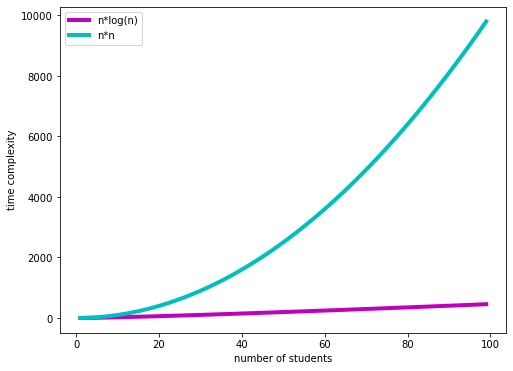

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import math

X = np.arange(1,100)
y = np.log(X)*X
z = X*X
plt.figure(figsize=(8, 6))
plt.plot(X, y, color='m', label='n*log(n)', linewidth=4.0)
plt.plot(X, z, color='c', label='n*n',linewidth=4.0)
plt.xlabel("number of students")
plt.ylabel("time complexity")
plt.legend()
plt.show()

In the previous plot there are the functions $nlog(n)$ and $n^2$ where n is the number of students.    
We've decided to show this plot in order to let you visualize the great gap that we have between the two functions when $n$ is large. In particular we can notice that the more n grows the more the gap increases.    
We can assert that if we have to sort a lot of elements is always better to use an algorithm that has a computational time of $nlog(n)$.

#### 3. Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.

As we've seen before the times taken by the different algorithm are:
- **insertion sort**: 7.0 minutes and 40.54 seconds
- **merge sort**: 0.0 minutes and 0.96 seconds
- **quick sort**: 0.0 minutes and 44.82 seconds

Now we are going to study how the computational cost for these 3 sorting algorithms varias as the number of operations, and thus the number of data to be analyzed: obviously the algorithm will require more time if the data are more, but the increase will be different for the tree considered functions.

we repeat insertion sort, mergesort, and quicksort repeatedly on sublists of our original list of 50000 data, and each time we save our execution time. for the first try we use 5 sublists.

I will then eventually have a list of n (in the first case 5) times where in position 1 i have the time considered for 50000/n data, in second position (50000/n)x2 data, until i have in last position all 50000 data.

In [26]:
d,n,m = read_file()

In [34]:
times_insertion = []
for t in tqdm(range(1000,len(d)+1,1000)):
    dati_time = d[0:t]
    start_time = time.time()
    insertion_sort(dati_time,t)
    end_time = time.time()
    times_insertion.append(end_time-start_time)

 16%|█▌        | 8/50 [00:26<02:21,  3.36s/it]


KeyboardInterrupt: 

In [32]:
print(times_insertion)

[20.524598836898804, 61.89326357841492, 117.12659430503845, 216.60043334960938, 381.2650661468506]


In [27]:
times_merge = []
for t in range(1000,len(d)+1,1000):
    dati_time = d[0:t]
    start_time = time.time()
    merge_sort(dati_time,1,t)
    end_time = time.time()
    times_merge.append(end_time-start_time)

In [28]:
print(times_merge)

[0.016216516494750977, 0.016015291213989258, 0.04646468162536621, 0.04790234565734863, 0.06406569480895996, 0.06399059295654297, 0.09598612785339355, 0.1040198802947998, 0.12793993949890137, 0.13605666160583496, 0.15991449356079102, 0.18408632278442383, 0.2799992561340332, 0.2319931983947754, 0.23200058937072754, 0.45059919357299805, 0.49712204933166504, 0.5385229587554932, 0.6523942947387695, 0.6629135608673096, 0.7520298957824707, 0.8980677127838135, 0.8420748710632324, 0.5869197845458984, 0.5617423057556152, 0.5972549915313721, 1.0289478302001953, 0.9575560092926025, 1.0510375499725342, 0.9393703937530518, 0.9589235782623291, 1.1938095092773438, 0.9446508884429932, 0.620079517364502, 0.5587747097015381, 0.9517004489898682, 0.6480648517608643, 1.0590178966522217, 1.365992784500122, 1.1729567050933838, 1.363377332687378, 0.8871357440948486, 0.7420783042907715, 0.7503929138183594, 0.7495701313018799, 0.7759747505187988, 0.7918670177459717, 0.8069150447845459, 0.8264570236206055, 0.8579

In [29]:
times_quick = []
for t in range(1000,len(d)+1,1000):
    dati_time = d[0:t]
    start_time = time.time()
    quicksort(dati_time,0,t-1)
    end_time = time.time()
    times_quick.append(end_time-start_time)

In [30]:
print(times_quick)

[0.06214284896850586, 0.12215685844421387, 0.2370157241821289, 0.4898667335510254, 0.8531427383422852, 0.6656582355499268, 0.9008142948150635, 1.1670353412628174, 1.4149880409240723, 3.2594380378723145, 5.018204689025879, 4.963103771209717, 2.8089561462402344, 3.2572381496429443, 3.739773750305176, 4.316369533538818, 4.82522177696228, 5.529625654220581, 6.859709739685059, 10.576805114746094, 16.965047597885132, 19.595900535583496, 18.72207760810852, 13.62497353553772, 11.323594808578491, 11.4913911819458, 12.497809886932373, 13.371950149536133, 14.17105746269226, 15.72263479232788, 17.278788089752197, 17.95663094520569, 22.763742923736572, 20.390027284622192, 22.896791458129883, 25.20660662651062, 23.380861282348633, 24.7302405834198, 32.03748154640198, 35.36314105987549, 28.630952835083008, 30.74528193473816, 33.97361922264099, 44.8653724193573, 56.59299659729004, 67.09026026725769, 56.16077518463135, 54.53713893890381, 64.49218273162842, 45.3176805973053]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

X = np.arange(10000,50000+1,10000)
ins = np.array(times_insertion)
mer = np.array(times_merge)
qui = np.array(times_quick)
plt.figure(figsize=(8, 6))
plt.plot(X, ins, color='m',label='insertion',linewidth=4.0)
plt.plot(X, mer, color='g',label='merge',linewidth=4.0)
plt.plot(X, qui, color='c',label='quick',linewidth=4.0)
plt.legend()
plt.show()

in the graph there are the 3 sorting algorithm (insertion, merge and quick) and their time trend with the increase of number of students to be analyzed.

#### 4. What is the most optimal algorithm, in your opinion, and why?

If we have to take a decision considering only the execution time of the algorithm we may say that the merge sort is the best one since it's the faster one.  
But even quick sort when we are not in particular case is a good one because it has a plus over merge sort.   
In fact even if merge sort is very fast we can notice that in the function merge we can't reorder the list without creating a new list in which store temporarily the new sorted elements and so we use more memory. Instead in the quick sort we can sort all the elements in loco.   
For this reason if we are in the cases in which quick sort takes a time complexity of $nlog(n)$ it's the best one to use.

#### 5. Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.